# Importing Libraries

In [ ]:
import os
from dotenv import load_dotenv

from langgraph.graph import START, END, StateGraph, MessagesState
from langchain.tools import tool
from langgraph.prebuilt import ToolNode
from typing import Literal

from langchain_together import ChatTogether

load_dotenv()

TOGETHER_API_KEY = os.getenv("TOGETHER_API_KEY")
together_model_name = "Qwen/Qwen3-235B-A22B-Instruct-2507-tput"

llm = ChatTogether(
    together_api_key=TOGETHER_API_KEY,
    model=together_model_name,
)


### Literal
In Python's typing module, a Literal type hint specifies that a variable or function parameter/return value must be exactly one of a set of specific, constant values. This differs from a regular type hint like str or int, which indicates the type of value, but not its specific content.

#### Key characteristics of Literal:

##### Exact Value Restriction:
It enforces that a value must precisely match one of the provided literal arguments. For example, Literal["red", "green", "blue"] means the value can only be the string "red", "green", or "blue", and nothing else.
Subtype of Parent Type:
A Literal type is a subtype of the underlying type of the literal values. For instance, Literal[3] is a subtype of int.

##### Immutability:
The values within a Literal type hint are implicitly considered immutable. This means you cannot use mutable data structures like lists or dictionaries directly within Literal (e.g., Literal[[1, 2]] is not allowed).

##### Enhanced Type Checking:
Literal types allow static type checkers (like MyPy) to provide more precise analysis and catch potential errors where a value might not conform to the expected exact literal.
Use Cases:

##### Function Overloads: Defining different return types based on specific input literal values.
API Design: Specifying exact allowed values for configuration options or modes.
Enums (Alternative): While Python has Enum for similar purposes, Literal can be a lightweight alternative for a small, fixed set of values.

# Defining Tools

In [6]:
from langchain.tools import tool

@tool

def get_weather(location: str):
    """
    Call to get the current weather
    """

    if location.lower() in ['bengaluru', "mysuru"]:
        return "It is 23 degrees Celsius and cloudy."
    else:
        return "It is 25 degree Celsius and sunny."
    

@tool
def check_seating_availability(location: str, seating_type: str):
    """
    Call to check seating availability
    """

    if location.lower() == "bengaluru" and seating_type.lower()=="outdoor":
        return "Yes, we still have seats available outdoors."
    elif location.lower() == "bengaluru" and seating_type.lower() == "indoor":
        return "Yes, we have indoor seating available."
    else:
        return "Sorry, seating information for this location is unavailable."
    
tools = [get_weather, check_seating_availability]

In [7]:
get_weather.invoke(input={"location": "bengaluru"})

'It is 23 degrees Celsius and cloudy.'

In [8]:
llm.invoke("Hello")

AIMessage(content='Hi there! ٩(◕‿◕｡)۶ How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 9, 'total_tokens': 31, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Qwen/Qwen3-235B-A22B-Instruct-2507-tput', 'system_fingerprint': None, 'id': 'o8Gx2PV-zqrih-9738f6778e7f8839', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--6c2de78d-766c-4d20-99b2-d6bd71453143-0', usage_metadata={'input_tokens': 9, 'output_tokens': 22, 'total_tokens': 31, 'input_token_details': {}, 'output_token_details': {}})

### Binding LLM with tools

In [20]:
llm_with_tools = llm.bind_tools(tools)

# Adding states

In [21]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

# Creating Workflow for graphs

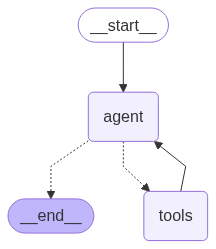

In [22]:
workflow = StateGraph(MessagesState)
tool_node = ToolNode(tools)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue)
workflow.add_edge("tools", "agent")

graph = workflow.compile()
graph

# Setting up messaging feature

In [23]:
from langchain_core.messages import HumanMessage

messages1 = [HumanMessage(content="Hello, how are you?")]
messages2 = [HumanMessage(content="How is the weather in Bengaluru?")]

In [24]:
res1 = graph.invoke({"messages": messages1})
res1

{'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='0e8db05d-487c-419f-948f-8b42e9a608bd'),
  AIMessage(content="Hello! I'm just a program, so I don't have feelings, but thanks for asking! How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 226, 'total_tokens': 254, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Qwen/Qwen3-235B-A22B-Instruct-2507-tput', 'system_fingerprint': None, 'id': 'o8GzfrZ-28Eivz-973903168e007679', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--7fc001c7-d9a7-4e91-8448-342fe4c0be4b-0', usage_metadata={'input_tokens': 226, 'output_tokens': 28, 'total_tokens': 254, 'input_token_details': {}, 'output_token_details': {}})]}

In [25]:
res2 = graph.invoke({"messages": messages2})
res2

{'messages': [HumanMessage(content='How is the weather in Bengaluru?', additional_kwargs={}, response_metadata={}, id='7c981781-0b75-4e87-b7ef-3ff505c7d710'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fy7f95elrwexxp3gz57t5t5a', 'function': {'arguments': '{"location":"Bengaluru"}', 'name': 'get_weather'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 228, 'total_tokens': 251, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Qwen/Qwen3-235B-A22B-Instruct-2507-tput', 'system_fingerprint': None, 'id': 'o8Gzh8K-28Eivz-9739032f48227679', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--766dc528-8f7f-47e9-83ae-e03c340f1393-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Bengaluru'}, 'id': 'call_fy7f95elrwexxp3gz57t5t5a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 228, 'output_tokens': 23, 'tot

In [26]:
messages3 = [HumanMessage(content="What would you recommend to do in that city then?")]
res3 = graph.invoke({"messages": messages3})
res3

{'messages': [HumanMessage(content='What would you recommend to do in that city then?', additional_kwargs={}, response_metadata={}, id='0896bf04-8e6a-4b34-89aa-fa9e123d2c4b'),
  AIMessage(content="Could you please specify which city you're referring to? That way, I can provide more accurate recommendations!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 231, 'total_tokens': 253, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Qwen/Qwen3-235B-A22B-Instruct-2507-tput', 'system_fingerprint': None, 'id': 'o8GzmS6-zqrih-9739038cfe86b080', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--9455c7fe-1d83-4d12-865c-09fdbaf8de97-0', usage_metadata={'input_tokens': 231, 'output_tokens': 22, 'total_tokens': 253, 'input_token_details': {}, 'output_token_details': {}})]}

# Adding Memory to Chatbot

In [29]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()
checkpointer

## Updated workflow

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


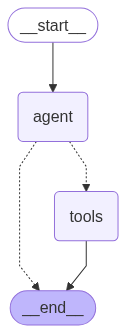

In [31]:
updated_workflow = StateGraph(MessagesState)
tool_node = ToolNode(tools)

updated_workflow.add_node("agent", call_model)
updated_workflow.add_node("tools", tool_node)

updated_workflow.add_edge(START, "agent")
updated_workflow.add_conditional_edges("agent", should_continue)
workflow.add_edge("tools", "agent")

updated_graph = updated_workflow.compile(checkpointer=checkpointer)
updated_graph

In [32]:
update_res1 = updated_graph.invoke(
    {"messages": messages2},
    config={"configurable": {"thread_id": 1}},
)
update_res1

{'messages': [HumanMessage(content='How is the weather in Bengaluru?', additional_kwargs={}, response_metadata={}, id='7c981781-0b75-4e87-b7ef-3ff505c7d710'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ae990ml6dw5xpfig7zo4if7c', 'function': {'arguments': '{"location":"Bengaluru"}', 'name': 'get_weather'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 228, 'total_tokens': 251, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Qwen/Qwen3-235B-A22B-Instruct-2507-tput', 'system_fingerprint': None, 'id': 'o8H3Y41-28Eivz-973910b86af5c190', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c2752854-7dab-4939-bfd5-90eb00f0646e-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Bengaluru'}, 'id': 'call_ae990ml6dw5xpfig7zo4if7c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 228, 'output_tokens': 23, 'tot

In [33]:
update_res2 = updated_graph.invoke(
    {"messages": messages3},
    config={"configurable": {"thread_id": 1}},
)
update_res2

{'messages': [HumanMessage(content='How is the weather in Bengaluru?', additional_kwargs={}, response_metadata={}, id='7c981781-0b75-4e87-b7ef-3ff505c7d710'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ae990ml6dw5xpfig7zo4if7c', 'function': {'arguments': '{"location":"Bengaluru"}', 'name': 'get_weather'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 228, 'total_tokens': 251, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Qwen/Qwen3-235B-A22B-Instruct-2507-tput', 'system_fingerprint': None, 'id': 'o8H3Y41-28Eivz-973910b86af5c190', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c2752854-7dab-4939-bfd5-90eb00f0646e-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Bengaluru'}, 'id': 'call_ae990ml6dw5xpfig7zo4if7c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 228, 'output_tokens': 23, 'tot

In [39]:
(update_res2['messages'][-1].content)

"Given that it's 23°C and cloudy in Bengaluru, it's a pleasant weather for outdoor activities. You could consider visiting some of the city's beautiful gardens like Lalbagh Botanical Garden or Cubbon Park for a relaxing stroll. You might also explore cultural spots like the Bangalore Palace or take a trip to one of the many tech museums or art galleries. If you're in the mood for shopping or cafes, places like Commercial Street or Indiranagar offer great options. Would you like recommendations for a specific type of activity?"